In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
#import kornia
#from network import MobileNetV1
from shuffle import ShuffleNet2

In [2]:
# Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToTensor(),
        #kornia.augmentation.RandomSharpness(0.5),
        #transforms.RandomApply([kornia.filters.GaussianBlur2d((3, 3), (1.5, 1.5))], p=0.2),
        #transforms.RandomApply([kornia.filters.MotionBlur(3, 17., 0.5)], p=0.2),
        #transforms.Lambda(lambda x: x.squeeze(0)),
        #transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.3, contrast=0.0, saturation=0.0),
        transforms.Grayscale(),
        #transforms.RandomAffine(0, shear=10),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(0.2, scale=(0.02, 0.23), ratio=(0.1, 1.3), value=0, inplace=True),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [3]:
#Training the model


def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scaler.update()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
data_dir = 'data/mask'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=192,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Visualize a few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp.squeeze())
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


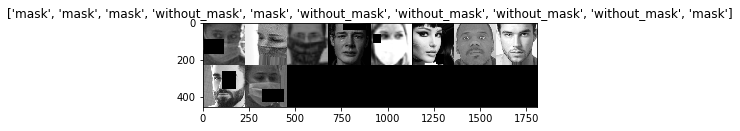

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10])

imshow(out, title=[class_names[x] for x in classes[:10]])

In [7]:
#Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [22]:
#Finetuning the convnet 
#Load a pretrained model and reset final fully connected layer.
#model_ft = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
#model_ft = torch.hub.load('rwightman/pytorch-image-models', 'resnet18', pretrained=True, num_classes=2,in_chans=1)
model_ft = ShuffleNet2(mask=True)
#model_ft.load_state_dict(torch.load('finetuned_model_shuf-gray-mask2.pth').state_dict())
model_ft = torch.load('finetuned_model_shuf-gray-mask2.pth')
model_ft.mask=True
model_ft = model_ft.to('cuda')

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [26]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0685 Acc: 0.9727
val Loss: 0.1093 Acc: 0.9621

Epoch 1/9
----------
train Loss: 0.0688 Acc: 0.9736
val Loss: 0.1086 Acc: 0.9656

Epoch 2/9
----------
train Loss: 0.0619 Acc: 0.9762
val Loss: 0.1087 Acc: 0.9646

Epoch 3/9
----------
train Loss: 0.0674 Acc: 0.9746
val Loss: 0.1077 Acc: 0.9674

Epoch 4/9
----------
train Loss: 0.0689 Acc: 0.9736
val Loss: 0.1088 Acc: 0.9642

Epoch 5/9
----------
train Loss: 0.0684 Acc: 0.9739
val Loss: 0.1018 Acc: 0.9653

Epoch 6/9
----------
train Loss: 0.0588 Acc: 0.9772
val Loss: 0.1073 Acc: 0.9628

Epoch 7/9
----------
train Loss: 0.0553 Acc: 0.9781
val Loss: 0.1061 Acc: 0.9628

Epoch 8/9
----------
train Loss: 0.0618 Acc: 0.9771
val Loss: 0.1048 Acc: 0.9617

Epoch 9/9
----------
train Loss: 0.0620 Acc: 0.9762
val Loss: 0.1138 Acc: 0.9624

Training complete in 1m 55s
Best val Acc: 0.967399


In [28]:
with torch.no_grad():
    torch.save(model_ft, 'finetuned_model_shuf-gray-mask2.pth')
    x = torch.randn(1,1,224,224).to('cuda')
    torch.jit.trace(model_ft, x).save('ft_model_shuf-gray-mask2.pt')


TracingCheckError: Tracing failed sanity checks!
Encountered an exception while running the trace with test inputs.
Exception:
	The following operation failed in the TorchScript interpreter.
	Traceback of TorchScript (most recent call last):
	RuntimeError: CUDA driver error: PTX JIT compiler library not found


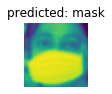

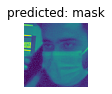

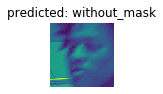

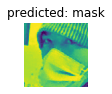

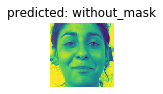

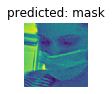

In [13]:
visualize_model(model_ft)


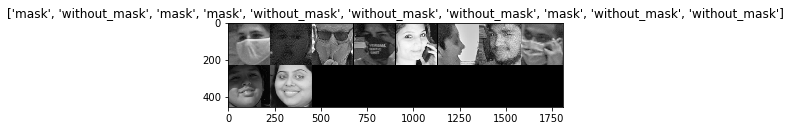

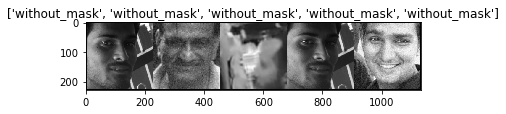

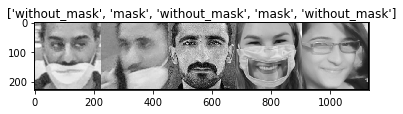

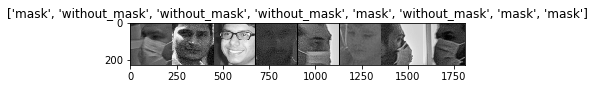

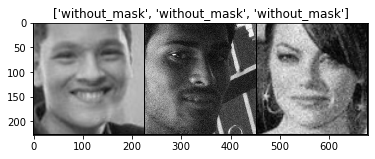

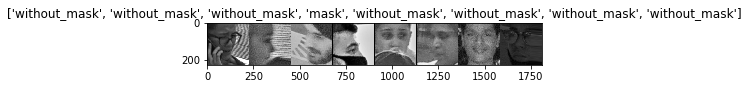

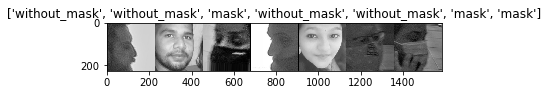

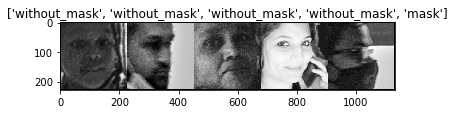

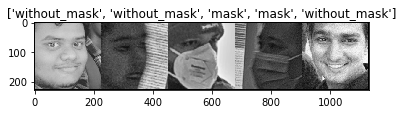

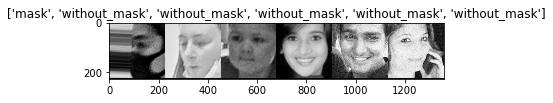

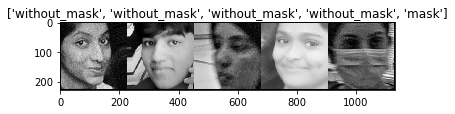

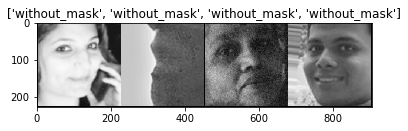

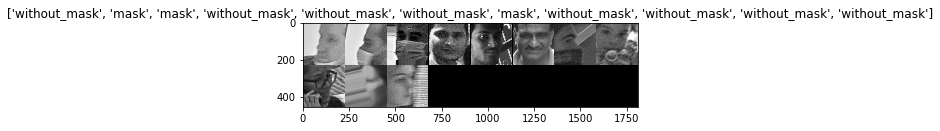

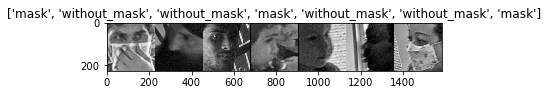

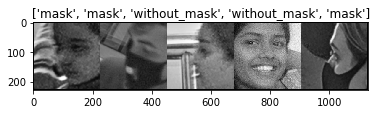

Model accuracy on 2822 test images: 96.67%


In [23]:
#Predicting the Category for all Test Images
# Confusion_matrix
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([2,2], int)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        indices = (predicted != labels)
        
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1
        if indices.sum() > 0:
            out = torchvision.utils.make_grid(data[0][indices])
            imshow(out, title=[class_names[x] for x in data[1][indices]])

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

In [24]:
#class_wise accuracy
print('{0:5s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:5s} : {1:.1f}'.format(class_names[i], r[i]/np.sum(r)*100))

Category : Accuracy
mask  : 98.6
without_mask : 92.2


In [25]:

print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     mask      without_mask
mask            1953      28        
without_mask    66        775       


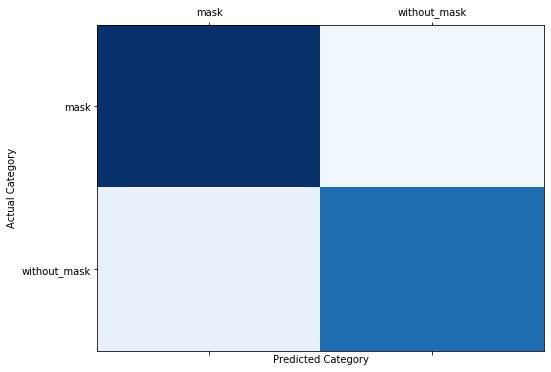

In [17]:

#plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(2), class_names)
plt.xlabel('Predicted Category')
plt.xticks(range(2), class_names)
plt.show()